# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [25]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, MaxPool1D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Loading Data

-> mitbih dataset contains information about **ARRHYTHMIA**

In [4]:
train = pd.read_csv("datasets/mitbih_train.csv",header=None)
test = pd.read_csv("datasets/mitbih_test.csv",header=None)

In [5]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Checking the labels in train and test set

In [6]:
print(" Train set Classes : ", train.iloc[:, -1].unique())
print(" Test set Classes : ", test.iloc[:, -1].unique())

 Train set Classes :  [0. 1. 2. 3. 4.]
 Test set Classes :  [0. 1. 2. 3. 4.]


## Changing the dType to int64

In [7]:
train[187]=train[187].astype("int64")
test[187]=test[187].astype("int64")

In [8]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(187), int64(1)
memory usage: 125.6 MB
None


# EDA

The meaning of each class:

0: "Normal",

1: "Artial Premature",

2: "Premature ventricular contraction",

3: "Fusion of ventricular and normal",

4: "Fusion of paced and normal"

In [9]:
print(" Train set Classes : ", train.iloc[:, -1].unique())
print(" Test set Classes : ", test.iloc[:, -1].unique())

 Train set Classes :  [0 1 2 3 4]
 Test set Classes :  [0 1 2 3 4]


In [10]:
# Mapping classes with the names
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

# Calculate value counts and rename index using the labels dictionary
value_counts = train.iloc[:,-1].value_counts().rename(labels)

# Create the bar plot to see the count of labels
bar_fig = px.bar(x=value_counts.index, y=value_counts.values,
                labels = {'x':'Labels', 'y':'Counts'},
                 text_auto=True,
                 title="The Count of Each Label in The Train Dataset"
                )

pie_fig = px.pie(names=value_counts.index, values=value_counts.values,
                 title="The Percentage of Each Label in The Train Dataset")

bar_fig.update_layout(title_x=0.5, width=800, height=600)
pie_fig.update_layout(title_x=0.5, width=800, height=600)
bar_fig.show()
pie_fig.show()

### ECG of a Person

<Axes: title={'center': 'ECG of First Person'}>

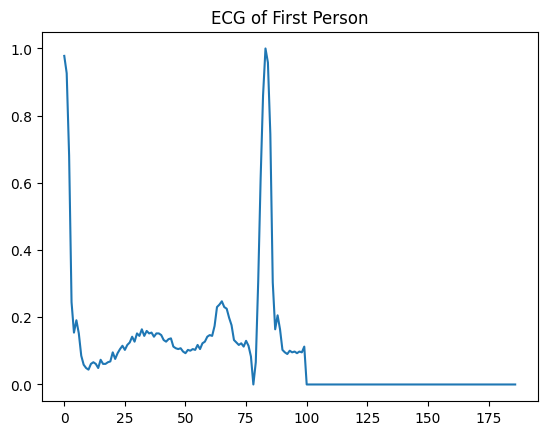

In [11]:
train.iloc[0, :187].plot(title='ECG of First Person')

### Comparing ECG's of different classes

In [12]:
n = random_index = np.random.randint(100)

ecg_0 = train.loc[train[187]==0, :].iloc[n,:187]
ecg_1 = train.loc[train[187]==1, :].iloc[n,:187]
ecg_2 = train.loc[train[187]==2, :].iloc[n,:187]
ecg_3 = train.loc[train[187]==3, :].iloc[n,:187]
ecg_4 = train.loc[train[187]==4, :].iloc[n,:187]

ecg_df = pd.DataFrame({'Normal': ecg_0,
                       'Artial Premature': ecg_1,
                       'Premature ventricular contraction': ecg_2,
                       'Fusion of ventricular and normal': ecg_3,
                       'Fusion of paced and normal': ecg_4})

In [13]:
ecg_plot = px.line(ecg_df,
                  labels={'index':'Time Intervals', 'value':'Amplitude (mV)', 'variable':'Categories'},
                  title="One ECG form Each Category")
ecg_plot.update_layout(title_x=0.25, width=1000, height=500)
ecg_plot.show()

# Data PreProcessing

### Data Augmentation for balancing the Dataset

In [14]:
train.shape

(87554, 188)

In [15]:
data = train.iloc[:, :187]
labels = train.iloc[:, 187]

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
data_resampled, labels_resampled = ros.fit_resample(data, labels)

train_df = pd.concat([data_resampled, labels_resampled], axis=1)

train_df.shape

(362355, 188)

In [16]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

# Calculate value counts and rename index using the labels dictionary
value_counts = train_df.iloc[:,-1].value_counts().rename(labels)

# Create the bar plot to see the count of labels
bar_fig = px.bar(x=value_counts.index, y=value_counts.values,
                labels = {'x':'Labels', 'y':'Counts'},
                 text_auto=True,
                 title="The Count of Each Label After Balancing"
                )

pie_fig = px.pie(names=value_counts.index, values=value_counts.values,
                 title="The Percentage of Each Label After Balancing")

bar_fig.update_layout(title_x=0.5, width=800, height=600)
pie_fig.update_layout(title_x=0.5, width=800, height=600)
bar_fig.show()
pie_fig.show()


# Splitting the Dataset

In [17]:
x_train, x_val, y_train, y_val = train_test_split(train_df.iloc[:, :187],
                                                train_df.iloc[:, 187],
                                                test_size= 0.2,
                                                stratify=train_df.iloc[:, 187],
                                                random_state=42)

x_test = test.iloc[:, :187]
y_test = test.iloc[:, 187]

### Converting DataFrame into Arrays

In [18]:
x_train = x_train.values
x_val = x_val.values
x_test = x_test.values

In [19]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (289884, 187)
y_train shape:  (289884,)
x_val shape:  (72471, 187)
y_val shape:  (72471,)
x_test shape:  (21892, 187)
y_test shape:  (21892,)


Before using the dataset in th e model,Lets add other dimension for cnn

In [20]:
x_train = x_train.reshape(x_train.shape[0], -1, 1)
x_val = x_val.reshape(x_val.shape[0], -1, 1)
x_test = x_test.reshape(x_test.shape[0], -1, 1)

# Using Model

### One Hot Encoding

In [21]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

### Creating the Model

In [22]:
model_cnn_lstm = Sequential([
    Input(shape=(x_train.shape[1:])),
    
    Conv1D(64, kernel_size=6, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding="same"),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=2, strides=2, padding="same"),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=2, strides=2, padding="same"),

    LSTM(64, return_sequences=True, activation="tanh"),
    
    LSTM(32, activation="tanh"),
    
    Flatten(),
    
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
    ])

model_cnn_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 182, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 182, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 89, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 89, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 43, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 22, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,717 (295.77 KB)

 Trainable params: 75,333 (294.27 KB)

 Non-trainable params: 384 (1.50 KB)

### Adam optimizer

In [23]:
model_cnn_lstm.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

### Callbacks

In [24]:
callbacks = [EarlyStopping(monitor='val_loss', 
                           patience=8),
             ReduceLROnPlateau(patience=20,
                               monitor='val_loss',
                               min_lr=1e-6,
                               cool_down=20)
             ]

### Training the Model

In [128]:
history = model_cnn_lstm.fit(x_train, y_train, 
                        epochs=4, 
                        callbacks=callbacks, 
                        batch_size=32, 
                        validation_data=(x_val, y_val),
                       verbose=1)

Epoch 1/4
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 300s 32ms/step - accuracy: 0.8706 - loss: 0.3545 - val_accuracy: 0.9700 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 2/4
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 159s 18ms/step - accuracy: 0.9744 - loss: 0.0754 - val_accuracy: 0.9012 - val_loss: 0.4206 - learning_rate: 0.0010
Epoch 3/4
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 164s 18ms/step - accuracy: 0.9847 - loss: 0.0470 - val_accuracy: 0.9805 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 4/4
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 174s 15ms/step - accuracy: 0.9894 - loss: 0.0339 - val_accuracy: 0.9866 - val_loss: 0.0393 - learning_rate: 0.0010


In [26]:
model = load_model("ECG_ARRHYTHMIA_Classification.h5")

### Plot loss and accuracy of the model

NameError: name 'history' is not defined

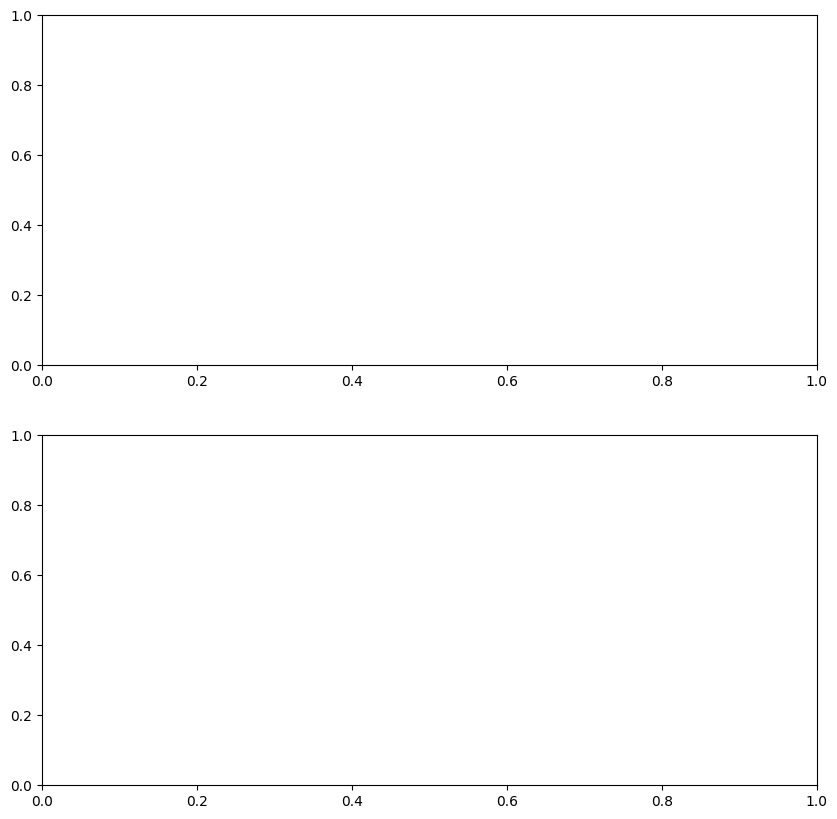

In [27]:
fig, axs = plt.subplots(2, figsize=(10, 10))

# Plot loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Predicting the outcome

In [30]:
y_pred = model.predict(x_test)

685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step


# Evaluation

### Comparision between training & validation sets

In [31]:
train_score = model.evaluate(x_train, y_train)
validation_score = model.evaluate(x_val, y_val)

print('Accuracy Train data: ', train_score[1])
print('Accuracy Validation data: ', validation_score[1])

9059/9059 ━━━━━━━━━━━━━━━━━━━━ 173s 19ms/step - accuracy: 0.9874 - loss: 0.0362
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - accuracy: 0.9871 - loss: 0.0382
Accuracy Train data:  0.9873880743980408
Accuracy Validation data:  0.9865877628326416


### Classification Report

In [32]:
# Convert one-hot encoded labels to integer labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.77      0.82      0.80       556
           2       0.92      0.96      0.94      1448
           3       0.66      0.88      0.75       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.87      0.93      0.89     21892
weighted avg       0.98      0.98      0.98     21892



In [33]:
model_cnn_lstm.save("ECG_ARRHYTHMIA_Classification.h5")